# Прогнозирование оттока клиентов для телеком компании

Оператор связи хочет уметь прогнозировать **отток клиентов**

Основываясь на этих прогнозах, будут предлагаться промокоды и специальные условия клиентам, которые планируют покинуть сервис

Оператор предоставляет два типа услуг:

1. Стационарная телефонная связь. Возможно подключить телефон к нескольким линиям одновременно.
2. Интернет. Подключение возможно двумя способами: DLS (через телефонную линию) или через оптоволоконный кабель


Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).


За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Цель:**
- создать модель прогнозирования оттока клиентов

**Метрика:**
- метрика для оценки качества модели ROC-AUC

**Точность:**
- ROC-AUC лучшей модели должен быть не ниже **0.78**

Для интерпретируемости модели необходимо, для каждой, вывести значение `accuracy`

**Описание данных**

**Данные хранятся в таблицах в базе данных `PostgreSQL`:**
* `contract` — информация о договоре,
* `personal` — персональные данные клиента,
* `internet` — информация об интернет-услугах,
* `phone` — информация об услугах телефонии.


**Таблица `telecom.contract`**
* `customerID` — ID пользователя,
* `BeginDate` — дата начала действия,
* `EndDate` — дата окончания действия,
* `Type` — тип оплаты (раз в год или помесячно),
* `PaperlessBilling` — безбумажный расчётный лист,
* `PaymentMethod` — тип платежа,
* `MonthlyCharges` — расход за месяц,
* `TotalCharges` — общие расходы.


**Таблица `personal`**
* `customerID` — ID пользователя,
* `gender` — пол,
* `SeniorCitizen` — является ли абонент пенсионером,
* `Partner` — есть ли у абонента супруг/супруга,
* `Dependents` — есть ли у абонента дети.


**Таблица `telecom.internet`**
* `customerID` — ID пользователя,
* `InternetService` — тип подключения,
* `OnlineSecurity` — блокировка небезопасных сайтов,
* `OnlineBackup` — облачное хранилище файлов для резервного копирования данных,
* `DeviceProtection` — антивирус,
* `TechSupport` — выделенная линия технической поддержки,
* `StreamingTV` — стриминговое телевидение,
* `StreamingMovies` — каталог фильмов.


**Таблица `telecom.phone`**
* `customerID` — ID пользователя,
* `MultipleLines` — подключение телефонного аппарата к нескольким линиям одновременно.

## Загрузка библиотек

In [1]:
# !pip install skimpy
# !pip install -U pandas-profiling[notebook]
# !jupyter nbextension enable --py widgetsnbextension
# !pip install optuna
# !pip install session-info

In [2]:
import pandas as pd
import numpy as np

from skimpy import skim
from pandas_profiling import ProfileReport
import phik

from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

import optuna

from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import time

In [3]:
import session_info

session_info.show()

In [4]:
sns.set_style(style='whitegrid')
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_palette("Set2")

In [5]:
RANDOM = 42
enc = OrdinalEncoder()
scaler = StandardScaler()

In [6]:
import warnings
warnings.filterwarnings('ignore')

## Подключение к базе и первичный осмотр

In [7]:
from db_config import db_config


connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

engine = create_engine(connection_string)

In [8]:
query = '''
SELECT * FROM information_schema.tables 
'''
tables = pd.read_sql_query(query, con=engine) 

In [9]:
# Хоть мы и знаем названия таблиц - все равно просмотрим
tables.table_name.unique()[:15]

array(['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp',
       'data_wire', 'data_wire_time', 'personal', 'phone', 'contract',
       'internet', 'pg_foreign_table', 'pg_roles', 'pg_settings',
       'pg_subscription'], dtype=object)

In [10]:
personal_query = '''SELECT * FROM telecom.personal'''
phone_query = '''SELECT * FROM telecom.phone'''
contract_query = '''SELECT * FROM telecom.contract'''
internet_query = '''SELECT * FROM telecom.internet'''

In [11]:
# Загрузим наши таблицы
personal_db = pd.read_sql_query(personal_query, con=engine)
phone_db = pd.read_sql_query(phone_query, con=engine)
contract_db = pd.read_sql_query(contract_query, con=engine, parse_dates=['BeginDate', 'EndDate'])
internet_db = pd.read_sql_query(internet_query, con=engine)

### Personal

In [12]:
skim(personal_db)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7043   │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 5      │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name           ┃ NA    ┃ NA %    ┃ mean    ┃ sd      ┃ p0   ┃ p25    ┃ p75    ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ SeniorCitizen         │     0 │       0 │    0.16 │    0.37 │    0 │      0 │      0 │       1 │  █    ▂   │  │
│ └───────────────────────┴───────┴─────────┴─────────┴─────────┴──────┴────────┴────────┴─────────┴───────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ customerID                │       0 │          0 │                            1 │                     7000 │  │
│ │ gender                    │       0 │          0 │                            1 │                     7000 │  │
│ │ Partner                   │       0 │          0 │                            1 │                     7000 │  │
│ │ Dependents                │       0 │          0 │                            1 │                     7000 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [13]:
ProfileReport(personal_db, title='Таблица Personal')

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


In [14]:
personal_db['SeniorCitizen'] = ['Yes' if x==1 else 'No' for x in personal_db['SeniorCitizen']]

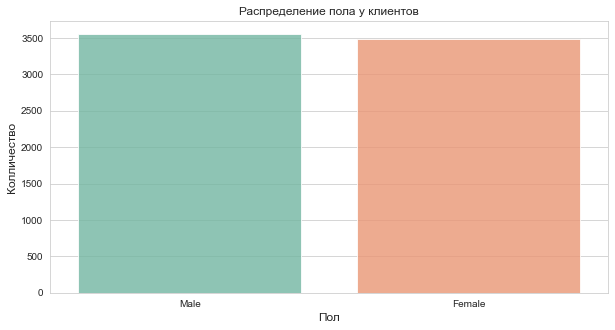

In [15]:
genders = personal_db.gender.value_counts()

sns.barplot(genders.index, genders.values, alpha=0.8)
plt.title('Распределение пола у клиентов')
plt.ylabel('Колличество', fontsize=12)
plt.xlabel('Пол', fontsize=12)
plt.show()

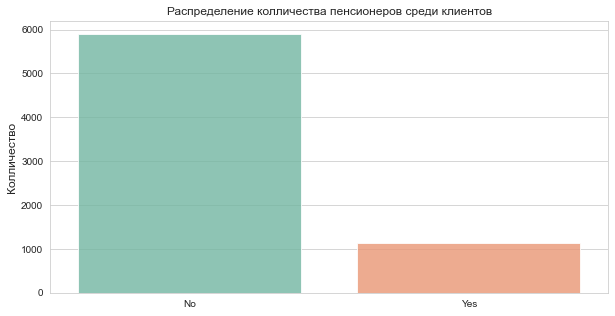

In [16]:
senior = personal_db.SeniorCitizen.value_counts()

sns.barplot(senior.index, senior.values, alpha=0.8)
plt.title('Распределение колличества пенсионеров среди клиентов')
plt.ylabel('Колличество', fontsize=12)
plt.show()

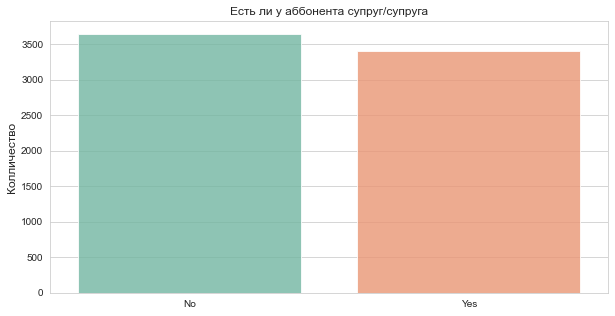

In [17]:
partner = personal_db.Partner.value_counts()

sns.barplot(partner.index, partner.values, alpha=0.8)
plt.title('Есть ли у аббонента супруг/супруга')
plt.ylabel('Колличество', fontsize=12)
plt.show()

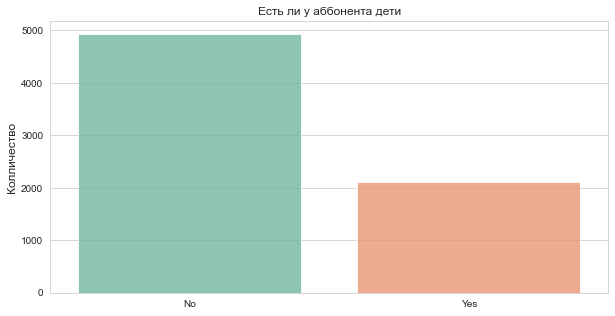

In [18]:
dependents = personal_db.Dependents.value_counts()

sns.barplot(dependents.index, dependents.values, alpha=0.8)
plt.title('Есть ли у аббонента дети')
plt.ylabel('Колличество', fontsize=12)
plt.show()

В таблице `personal`: 
- нет пропусков
- данные имеют правильные типы
- пол распределен равномерно
- в основном клиенты до пенсионного возраста
- так же преобладает кол-во клиентов без детей

### Phone

In [19]:
skim(phone_db)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 6362   │ │ string      │ 2     │                                                          │
│ │ Number of columns │ 2      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ c1                        │       0 │          0 │                            1 │                     6400 │  │
│ │ c2                        │       0 │          0 │                            1 │                     6400 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [20]:
ProfileReport(phone_db, title='Таблица Phone')

Render HTML: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


Видим ошибку в названиях колонок

Исправим

In [21]:
phone_db.columns = phone_db.iloc[0]
phone_db = phone_db[1:].reset_index(drop=True)

In [22]:
phone_db

0    customerID    MultipleLines
0       5575-GNVDE            No
1       3668-QPYBK            No
2       9237-HQITU            No
3       9305-CDSKC           Yes
4       1452-KIOVK           Yes
...            ...           ...
6356    2569-WGERO            No
6357    6840-RESVB           Yes
6358    2234-XADUH           Yes
6359    8361-LTMKD           Yes
6360    3186-AJIEK            No

[6361 rows x 2 columns]

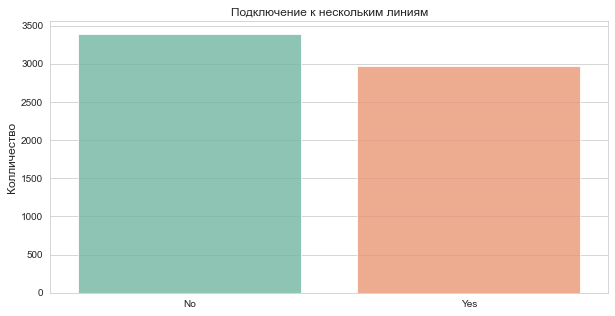

In [23]:
multilines = phone_db['MultipleLines'].value_counts()

sns.barplot(multilines.index, multilines.values, alpha=0.8)
plt.title('Подключение к нескольким линиям')
plt.ylabel('Колличество', fontsize=12)
plt.show()

В таблице `phone`: 
- была ошибка в названии колонок - исправил
- нет пропусков
- данные имеют правильные типы
- распределение подключения равномерное

### Contract

In [24]:
skim(contract_db)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7043   │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 8      │ │ datetime64  │ 2     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA   ┃ NA %    ┃ mean    ┃ sd      ┃ p0   ┃ p25    ┃ p75     ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ MonthlyCharges         │    0 │       0 │      65 │      30 │   18 │     36 │      90 │     120 │  █▃▄▇▇▃  │  │
│ │ TotalCharges           │   11 │    0.16 │    2300 │    2300 │   19 │    400 │    3800 │    8700 │  █▃▂▂▁▁  │  │
│ └────────────────────────┴──────┴─────────┴─────────┴─────────┴──────┴────────┴─────────┴─────────┴──────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name           ┃ NA        ┃ NA %      ┃ first              ┃ last               ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ BeginDate             │         0 │         0 │     2018-04-17     │     2020-02-01     │ None             │  │
│ │ EndDate               │      5200 │        73 │     2019-10-01     │     2020-01-01     │ None             │  │
│ └───────────────────────┴───────────┴───────────┴────────────────────┴────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                      ┃ NA     ┃ NA %      ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ customerID                       │      0 │         0 │                          1 │                  7000 │  │
│ │ Type                             │      0 │         0 │                          1 │                  7000 │  │
│ │ PaperlessBilling                 │      0 │         0 │                          1 │                  7000 │  │
│ │ PaymentMethod                    │      0 │         0 │                          1 │                  7000 │  │
│ └──────────────────────────────────┴────────┴───────────┴────────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [25]:
ProfileReport(contract_db, title='Таблица Contract')

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


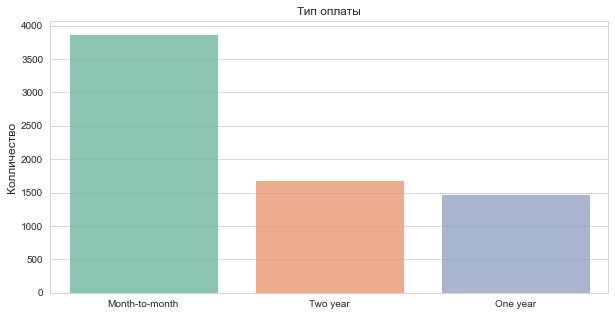

In [26]:
contr_type = contract_db.Type.value_counts()

sns.barplot(contr_type.index, contr_type.values, alpha=0.8)
plt.title('Тип оплаты')
plt.ylabel('Колличество', fontsize=12)
plt.show()

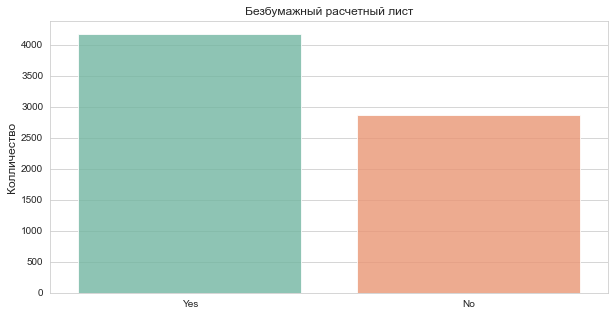

In [27]:
ppbilling = contract_db.PaperlessBilling.value_counts()

sns.barplot(ppbilling.index, ppbilling.values, alpha=0.8)
plt.title('Безбумажный расчетный лист')
plt.ylabel('Колличество', fontsize=12)
plt.show()

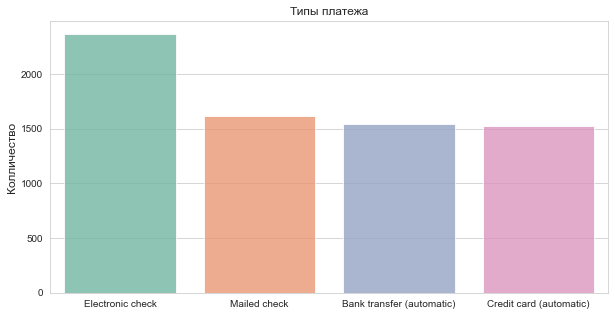

In [28]:
pay_method = contract_db.PaymentMethod.value_counts()

sns.barplot(pay_method.index, pay_method.values, alpha=0.8)
plt.title('Типы платежа')
plt.ylabel('Колличество', fontsize=12)
plt.show()

У колонок с датой заменим тип данных на `datetime`

In [29]:
contract_db[contract_db['TotalCharges'].isna()]

customerID  BeginDate EndDate      Type PaperlessBilling  \
0     4472-LVYGI 2020-02-01     NaT  Two year              Yes   
1     3115-CZMZD 2020-02-01     NaT  Two year               No   
3     5709-LVOEQ 2020-02-01     NaT  Two year               No   
6     4367-NUYAO 2020-02-01     NaT  Two year               No   
7     1371-DWPAZ 2020-02-01     NaT  Two year               No   
9     3213-VVOLG 2020-02-01     NaT  Two year               No   
10    2923-ARZLG 2020-02-01     NaT  One year              Yes   
11    2775-SEFEE 2020-02-01     NaT  Two year              Yes   
4408  7644-OMVMY 2020-02-01     NaT  Two year               No   
5160  2520-SGTTA 2020-02-01     NaT  Two year               No   
6839  4075-WKNIU 2020-02-01     NaT  Two year               No   

                  PaymentMethod  MonthlyCharges  TotalCharges  
0     Bank transfer (automatic)           52.55           NaN  
1                  Mailed check           20.25           NaN  
3                  Mailed check           80.85           NaN  
6                  Mailed check           25.75           NaN  
7       Credit card (automatic)           56.05           NaN  
9                  Mailed check           25.35           NaN  
10                 Mailed check           19.70           NaN  
11    Bank transfer (automatic)           61.90           NaN  
4408               Mailed check           19.85           NaN  
5160               Mailed check           20.00           NaN  
6839               Mailed check           73.35           NaN

Заменим пропуски в колонке `TotalCharges` на ежемесячный платеж

тк пропуски только у контрактов, которые начались 2020-02-01

In [30]:
tot_emp_ind = contract_db[contract_db['TotalCharges'].isna()].index

In [31]:
for i in tot_emp_ind:
    contract_db['TotalCharges'][i] = contract_db['MonthlyCharges'][i]

In [32]:
contract_db[contract_db['TotalCharges'].isna()]

Empty DataFrame
Columns: [customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges]
Index: []

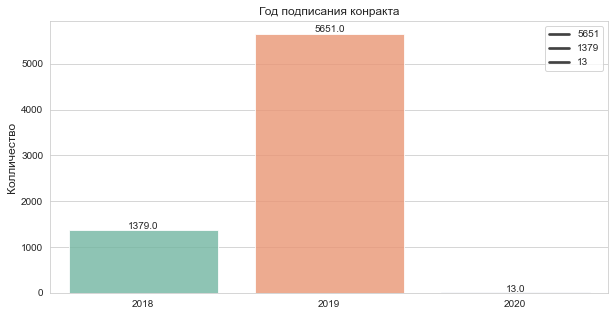

In [33]:
begin_date = contract_db.BeginDate.dt.year.value_counts()

ax = sns.barplot(begin_date.index, begin_date.values, alpha=0.8)
plt.title('Год подписания конракта')
plt.ylabel('Колличество', fontsize=12)
plt.legend(begin_date)


for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
    value = '{:.1f}'.format(p.get_height())
    ax.text(_x, _y, value, ha="center")

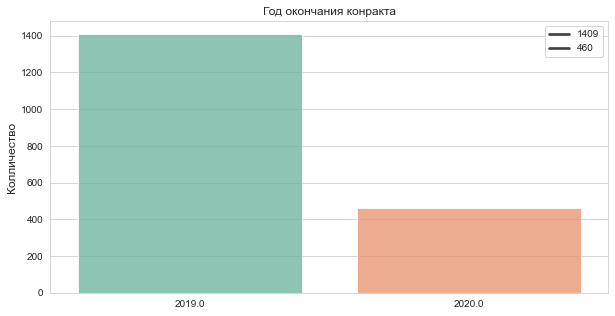

In [34]:
end_date = contract_db.EndDate.dt.year.value_counts()

sns.barplot(end_date.index, end_date.values, alpha=0.8)
plt.title('Год окончания конракта')
plt.ylabel('Колличество', fontsize=12)
plt.legend(end_date)

В таблице `contract`: 
- исправил типы данных в колонках с датой
- пропуски в дате окончания могут означать, что контракт еще не окончен
- основной тип оплаты по месяцам
- 2019 год самый активный для начала контракта
- 2019 год так же самый активный для отмены контракта

### Internet

In [35]:
skim(internet_db)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5518   │ │ string      │ 8     │                                                          │
│ │ Number of columns │ 8      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ c1                        │       0 │          0 │                            1 │                     5500 │  │
│ │ c2                        │       0 │          0 │                            1 │                     5500 │  │
│ │ c3                        │       0 │          0 │                            1 │                     5500 │  │
│ │ c4                        │       0 │          0 │                            1 │                     5500 │  │
│ │ c5                        │       0 │          0 │                            1 │                     5500 │  │
│ │ c6                        │       0 │          0 │                            1 │                     5500 │  │
│ │ c7                        │       0 │          0 │                            1 │                     5500 │  │
│ │ c8                        │       0 │          0 │                            1 │                     5500 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [36]:
internet_db.columns = internet_db.iloc[0]
internet_db = internet_db[1:].reset_index(drop=True)

In [37]:
ProfileReport(internet_db, title='Таблица Internet')

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


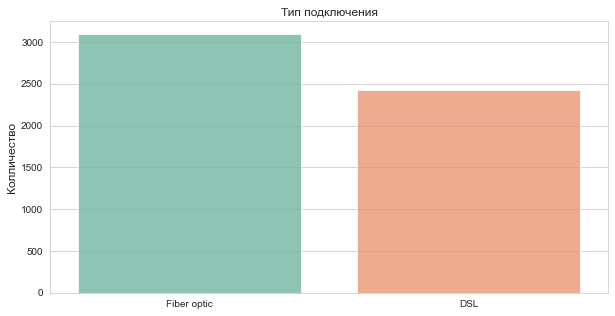

In [38]:
service = internet_db.InternetService.value_counts()

sns.barplot(service.index, service.values, alpha=0.8)
plt.title('Тип подключения')
plt.ylabel('Колличество', fontsize=12)
plt.show()

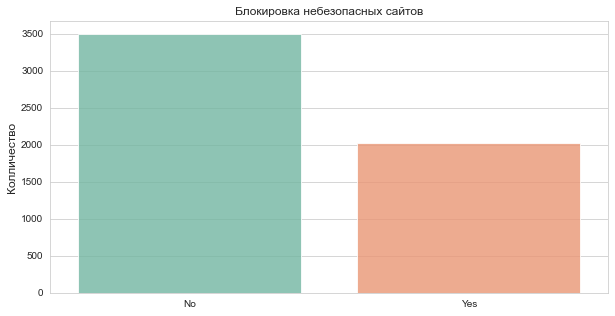

In [39]:
security = internet_db.OnlineSecurity.value_counts()

sns.barplot(security.index, security.values, alpha=0.8)
plt.title('Блокировка небезопасных сайтов')
plt.ylabel('Колличество', fontsize=12)
plt.show()

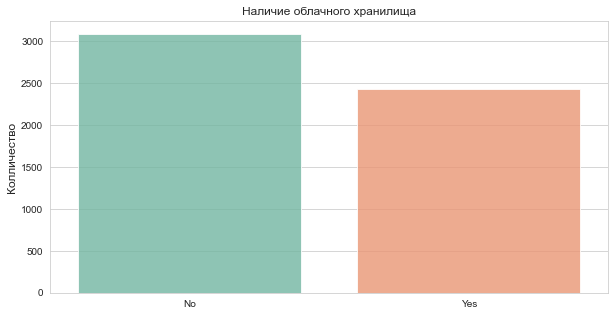

In [40]:
backup = internet_db.OnlineBackup.value_counts()

sns.barplot(backup.index, backup.values, alpha=0.8)
plt.title('Наличие облачного хранилища')
plt.ylabel('Колличество', fontsize=12)
plt.show()

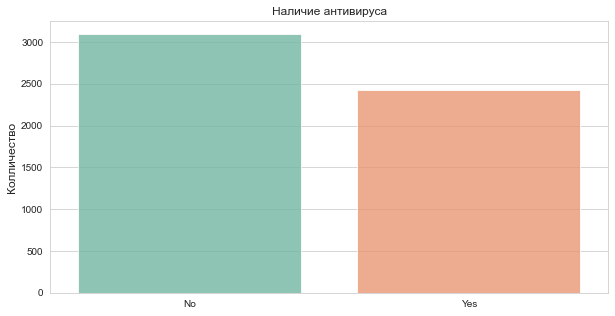

In [41]:
devprot = internet_db.DeviceProtection.value_counts()

sns.barplot(devprot.index, devprot.values, alpha=0.8)
plt.title('Наличие антивируса')
plt.ylabel('Колличество', fontsize=12)
plt.show()

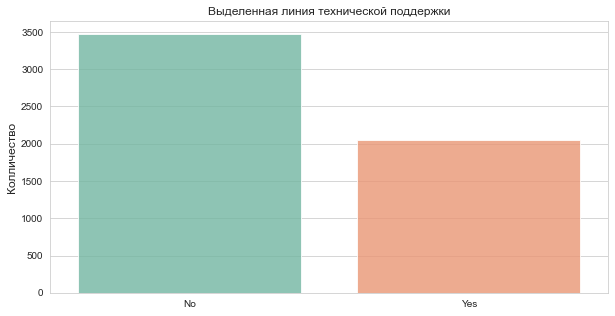

In [42]:
support = internet_db.TechSupport.value_counts()

sns.barplot(support.index, support.values, alpha=0.8)
plt.title('Выделенная линия технической поддержки')
plt.ylabel('Колличество', fontsize=12)
plt.show()

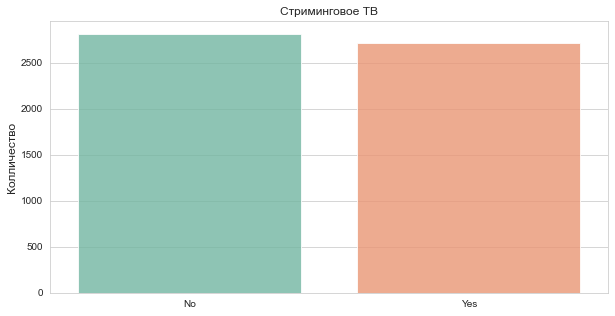

In [43]:
stream_tv = internet_db.StreamingTV.value_counts()

sns.barplot(stream_tv.index, stream_tv.values, alpha=0.8)
plt.title('Стриминговое ТВ')
plt.ylabel('Колличество', fontsize=12)
plt.show()

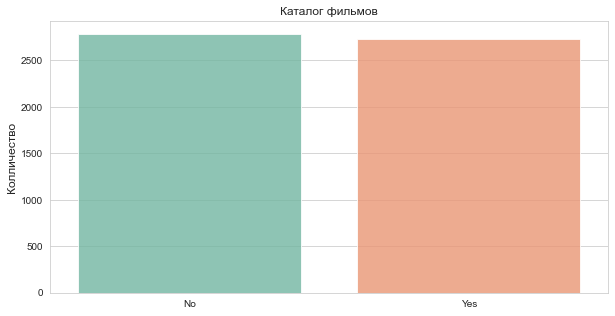

In [44]:
stream_mov = internet_db.StreamingMovies.value_counts()

sns.barplot(stream_mov.index, stream_mov.values, alpha=0.8)
plt.title('Каталог фильмов')
plt.ylabel('Колличество', fontsize=12)
plt.show()

В таблице `internet`: 
- исправил неверное обозначение колонок
- основной тип подключения по оптоволоконной сети
- большинство клиентов без дополнительных сервисов
- ровное распределение у стриммингового ТВ и Фильмов

**Вывод**

Мы имеем 4 датасета

У них есть общий ключ `customerID`

Сделана первичная обработка данных

## Сравнение групп

### Target

Создадим колонку с таргетом

Будем маркировать `0` если отсутствует дата окончания контракта и `1` если дата присутствует

In [45]:
contract_db['target'] = [1 if pd.notna(x) else 0 for x in contract_db['EndDate']]

### Визуализация групп

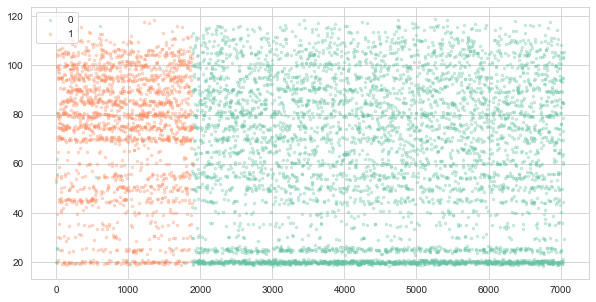

In [46]:
groups_monthly = contract_db.groupby('target')

fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups_monthly:
    ax.plot(group.MonthlyCharges, marker='.', linestyle='', ms=5, label=name, alpha=0.3)
ax.legend()

plt.show()

**Распределение ежемесячных платежей у бывших и текущих клиентов**

No handles with labels found to put in legend.


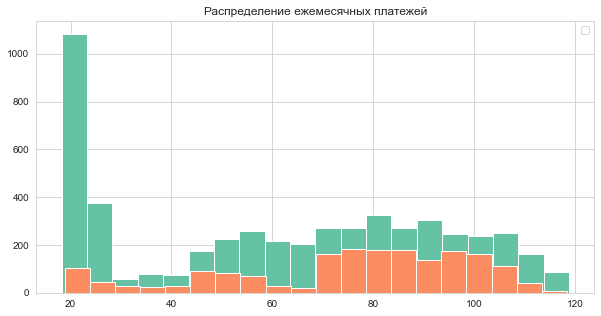

In [47]:
contract_db[contract_db['EndDate'].isna()]['MonthlyCharges'].hist(bins=20)
contract_db[~contract_db['EndDate'].isna()]['MonthlyCharges'].hist(bins=20)
plt.title('Распределение ежемесячных платежей')
plt.legend()
plt.show()

In [48]:
import plotly.express as px

In [49]:
fig = px.box(contract_db, x='target', y='MonthlyCharges')
fig.show()

In [50]:
fig = px.treemap(contract_db, path=['target', 'Type', 'PaymentMethod'], 
                values='TotalCharges', color='TotalCharges', hover_data=['EndDate'])
fig.show()

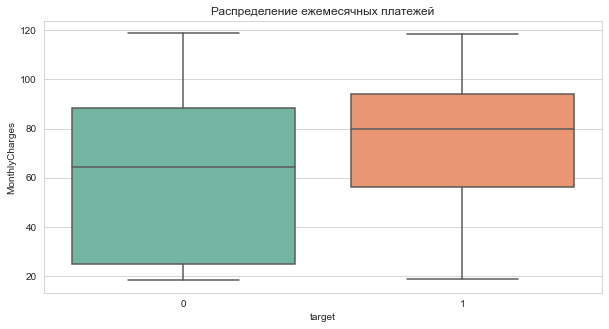

In [51]:
sns.boxplot(data=contract_db, x='target', y='MonthlyCharges')
plt.title('Распределение ежемесячных платежей')
plt.show()

In [52]:
stat_for_cl = pd.DataFrame(contract_db[contract_db['EndDate'].isna()]['MonthlyCharges'].describe()).reset_index()

In [53]:
stat_for_fcl = pd.DataFrame(contract_db[~contract_db['EndDate'].isna()]['MonthlyCharges'].describe()).reset_index()

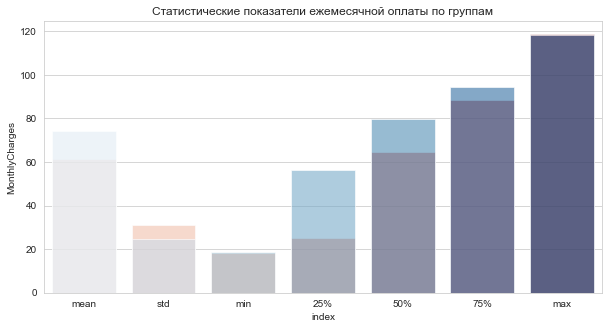

In [54]:
sns.barplot(data=stat_for_cl[1:], y='MonthlyCharges', x='index', alpha=0.6, palette='Reds')
sns.barplot(data=stat_for_fcl[1:], y='MonthlyCharges', x='index', alpha=0.6, palette='Blues')
plt.title('Статистические показатели ежемесячной оплаты по группам')
plt.show()

**Посчитаем долю клиентов и бывших клиентов, которые используют интернет и телефонную связь**

In [55]:
cl = contract_db[contract_db['EndDate'].isna()]
fcl = contract_db[~contract_db['EndDate'].isna()]

In [56]:
int_fcl = internet_db['customerID'].isin(fcl['customerID']).sum()
int_cl = internet_db['customerID'].isin(cl['customerID']).sum()
phone_fcl = phone_db['customerID'].isin(fcl['customerID']).sum()
phone_cl = phone_db['customerID'].isin(cl['customerID']).sum()

In [57]:
phone_int = {'count' : [int_fcl, int_cl, phone_fcl, phone_cl]}
phone_int = pd.DataFrame(phone_int, index=['internet_former_clients', 
                                            'internet_current_clients', 
                                            'phone_former_clients', 
                                            'phone_current_clients'])



In [58]:
phone_int

count
internet_former_clients    1756
internet_current_clients   3761
phone_former_clients       1699
phone_current_clients      4662

In [59]:
px.bar(phone_int, x = phone_int.index, y='count')

### Портрет уходящего клиента

Исходя из анализа, можно предварительно описать уходящего клиента:
- медиана ежемесячного платежа равняется **79.65**
- разброс ежемесячного платежа меньше чем у текущих клиентов (**56:94** к **25:88**)
- основной тип платежа `Month-to-month` с электронным чеком

## Объединение датасета

Будем считать, что таблица `contract_db` самая полная.

Следовательно к ней будем присоединять остальные таблицы.

In [60]:
df = contract_db.merge(personal_db, on='customerID', how='left')
df = df.merge(phone_db, on='customerID', how='left')
df = df.merge(internet_db, on='customerID', how='left')

### Обработка пропусков

In [61]:
df['EndDate'] = df['EndDate'].fillna('2020-02-01')

In [62]:
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')

Добавим количество месяцев, сколько юзер был клиентом компании

In [63]:
df['total_months'] = round((df['EndDate'] - df['BeginDate'])/np.timedelta64(1, 'M'))
df['total_months'] = df['total_months'].replace(0.0, 1.0)
df['total_months'] = df['total_months'].astype(int)

In [64]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
target                 0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
total_months           0
dtype: int64

Заполним пропуски `No`


In [65]:
df = df.fillna('No')

Пропуски заполнены

In [66]:
df

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0     4472-LVYGI 2020-02-01 2020-02-01        Two year              Yes   
1     3115-CZMZD 2020-02-01 2020-02-01        Two year               No   
2     3668-QPYBK 2018-08-09 2019-12-01  Month-to-month              Yes   
3     5709-LVOEQ 2020-02-01 2020-02-01        Two year               No   
4     9237-HQITU 2019-01-26 2019-11-01  Month-to-month              Yes   
...          ...        ...        ...             ...              ...   
7038  2569-WGERO 2019-01-21 2020-02-01        Two year              Yes   
7039  6840-RESVB 2019-02-26 2020-02-01        One year              Yes   
7040  2234-XADUH 2019-09-02 2020-02-01        One year              Yes   
7041  4801-JZAZL 2019-06-26 2020-02-01  Month-to-month              Yes   
7042  3186-AJIEK 2019-04-18 2020-02-01        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  target  gender  \
0     Bank transfer (automatic)           52.55         52.55       0  Female   
1                  Mailed check           20.25         20.25       0    Male   
2                  Mailed check           53.85        108.15       1    Male   
3                  Mailed check           80.85         80.85       0  Female   
4              Electronic check           70.70        151.65       1  Female   
...                         ...             ...           ...     ...     ...   
7038  Bank transfer (automatic)           21.15       1419.40       0  Female   
7039               Mailed check           84.80       1990.50       0    Male   
7040    Credit card (automatic)          103.20       7362.90       0  Female   
7041           Electronic check           29.60        346.45       0  Female   
7042  Bank transfer (automatic)          105.65       6844.50       0    Male   

      ... Dependents MultipleLines InternetService OnlineSecurity  \
0     ...        Yes            No             DSL            Yes   
1     ...        Yes            No              No             No   
2     ...         No            No             DSL            Yes   
3     ...        Yes            No             DSL            Yes   
4     ...         No            No     Fiber optic             No   
...   ...        ...           ...             ...            ...   
7038  ...         No            No              No             No   
7039  ...        Yes           Yes             DSL            Yes   
7040  ...        Yes           Yes     Fiber optic             No   
7041  ...        Yes            No             DSL            Yes   
7042  ...         No            No     Fiber optic            Yes   

     OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0              No              Yes         Yes         Yes              No   
1              No               No          No          No              No   
2             Yes               No          No          No              No   
3             Yes              Yes          No         Yes             Yes   
4              No               No          No          No              No   
...           ...              ...         ...         ...             ...   
7038           No               No          No          No              No   
7039           No              Yes         Yes         Yes             Yes   
7040          Yes              Yes          No         Yes             Yes   
7041           No               No          No          No              No   
7042           No              Yes         Yes         Yes             Yes   

     total_months  
0               1  
1               1  
2              16  
3               1  
4               9  
...           ...  
7038           12  
7039           11  
7040            5  
7041            7  
7042            9  

[7043 rows x 22 columns]

## Оценка корреляции с таргетом

In [67]:
phik_corr = df.phik_matrix()

phik_corr

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'total_months']


/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 3627145. Are interval variables set correctly?
  warnings.warn(


customerID  BeginDate   EndDate      Type  PaperlessBilling  \
customerID               1.0   1.000000  1.000000  1.000000          1.000000   
BeginDate                1.0   1.000000  0.522116  0.129357          0.035787   
EndDate                  1.0   0.522116  1.000000  0.357462          0.156832   
Type                     1.0   0.129357  0.357462  1.000000          0.106860   
PaperlessBilling         1.0   0.035787  0.156832  0.106860          1.000000   
PaymentMethod            1.0   0.098918  0.212169  0.277462          0.370495   
MonthlyCharges           1.0   0.187141  0.319733  0.388444          0.467812   
TotalCharges             1.0   0.000000  0.249842  0.505287          0.205901   
target                   1.0   0.487635  1.000000  0.251639          0.295754   
gender                   1.0   0.091464  0.000000  0.000000          0.000000   
SeniorCitizen            1.0   0.139137  0.123124  0.086231          0.242133   
Partner                  1.0   0.142517  0.121753  0.179736          0.013218   
Dependents               1.0   0.077740  0.133425  0.147680          0.172593   
MultipleLines            1.0   0.062805  0.034949  0.065498          0.252972   
InternetService          1.0   0.133047  0.288479  0.505187          0.231438   
OnlineSecurity           1.0   0.109448  0.139392  0.152145          0.000000   
OnlineBackup             1.0   0.000000  0.068364  0.098884          0.196443   
DeviceProtection         1.0   0.078877  0.051336  0.137610          0.160796   
TechSupport              1.0   0.000000  0.134227  0.179999          0.055929   
StreamingTV              1.0   0.057824  0.050373  0.066961          0.343524   
StreamingMovies          1.0   0.033073  0.047014  0.069608          0.325551   
total_months             1.0   0.975048  0.035198  0.018979          0.028094   

                  PaymentMethod  MonthlyCharges  TotalCharges    target  \
customerID             1.000000        1.000000      1.000000  1.000000   
BeginDate              0.098918        0.187141      0.000000  0.487635   
EndDate                0.212169        0.319733      0.249842  1.000000   
Type                   0.277462        0.388444      0.505287  0.251639   
PaperlessBilling       0.370495        0.467812      0.205901  0.295754   
PaymentMethod          1.000000        0.399526      0.350460  0.449125   
MonthlyCharges         0.399526        1.000000      0.762889  0.360050   
TotalCharges           0.350460        0.762889      1.000000  0.279152   
target                 0.449125        0.360050      0.279152  1.000000   
gender                 0.000000        0.008175      0.000000  0.000000   
SeniorCitizen          0.292725        0.304985      0.148755  0.233432   
Partner                0.243008        0.203545      0.422402  0.232930   
Dependents             0.224903        0.184366      0.114304  0.253936   
MultipleLines          0.339313        0.675883      0.605753  0.059581   
InternetService        0.323886        0.919002      0.508171  0.196202   
OnlineSecurity         0.262911        0.551621      0.544407  0.264580   
OnlineBackup           0.282475        0.629541      0.655082  0.126973   
DeviceProtection       0.306866        0.667481      0.671222  0.101516   
TechSupport            0.272101        0.576525      0.565910  0.254615   
StreamingTV            0.377209        0.835340      0.659672  0.096865   
StreamingMovies        0.378907        0.833307      0.666350  0.093923   
total_months           0.000000        0.000000      0.035512  0.024756   

                    gender  ...  Dependents  MultipleLines  InternetService  \
customerID        1.000000  ...    1.000000       1.000000         1.000000   
BeginDate         0.091464  ...    0.077740       0.062805         0.133047   
EndDate           0.000000  ...    0.133425       0.034949         0.288479   
Type              0.000000  ...    0.147680       0.065498         0.505187   
PaperlessBilling  0.000000  ...  

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'total_months']


/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 3627145. Are interval variables set correctly?
  warnings.warn(


<AxesSubplot:>

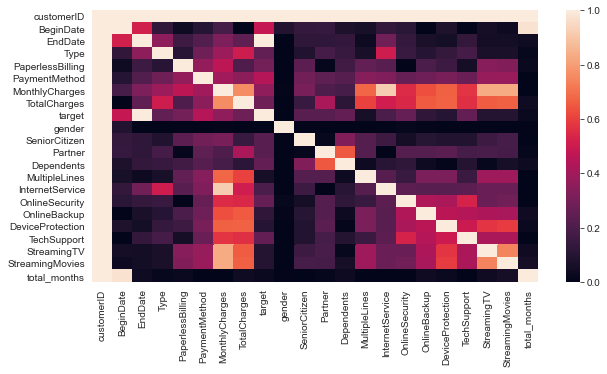

In [68]:
sns.heatmap(df.phik_matrix())

In [69]:
phik_corr.describe().T

count      mean       std  min       25%       50%  \
customerID         22.0  1.000000  0.000000  1.0  1.000000  1.000000   
BeginDate          22.0  0.243724  0.332054  0.0  0.059069  0.104183   
EndDate            22.0  0.274809  0.320430  0.0  0.055593  0.136810   
Type               22.0  0.260229  0.278400  0.0  0.089394  0.149912   
PaperlessBilling   22.0  0.257370  0.272949  0.0  0.068662  0.201172   
PaymentMethod      22.0  0.339203  0.243022  0.0  0.247984  0.299795   
MonthlyCharges     22.0  0.512517  0.303945  0.0  0.308672  0.509717   
TotalCharges       22.0  0.452321  0.297397  0.0  0.216886  0.506729   
target             22.0  0.321030  0.302834  0.0  0.107880  0.252788   
gender             22.0  0.096904  0.292957  0.0  0.000000  0.000000   
SeniorCitizen      22.0  0.226623  0.267100  0.0  0.091156  0.154729   
Partner            22.0  0.259244  0.280762  0.0  0.126944  0.198402   
Dependents         22.0  0.218240  0.289848  0.0  0.040202  0.119624   
MultipleLines      22.0  0.296010  0.291734  0.0  0.063478  0.223348   
InternetService    22.0  0.322416  0.295257  0.0  0.169577  0.236633   
OnlineSecurity     22.0  0.308110  0.280542  0.0  0.128556  0.252166   
OnlineBackup       22.0  0.326669  0.291973  0.0  0.099680  0.258039   
DeviceProtection   22.0  0.346825  0.303755  0.0  0.093393  0.272472   
TechSupport        22.0  0.324059  0.288982  0.0  0.106241  0.247139   
StreamingTV        22.0  0.363985  0.317025  0.0  0.074437  0.308171   
StreamingMovies    22.0  0.366432  0.315639  0.0  0.075687  0.307324   
total_months       22.0  0.151867  0.342024  0.0  0.000000  0.026425   

                       75%  max  
customerID        1.000000  1.0  
BeginDate         0.175985  1.0  
EndDate           0.311919  1.0  
Type              0.337462  1.0  
PaperlessBilling  0.318101  1.0  
PaymentMethod     0.375530  1.0  
MonthlyCharges    0.741137  1.0  
TotalCharges      0.658525  1.0  
target            0.343976  1.0  
gender            0.007124  1.0  
SeniorCitizen     0.239957  1.0  
Partner           0.236792  1.0  
Dependents        0.214769  1.0  
MultipleLines     0.379008  1.0  
InternetService   0.315034  1.0  
OnlineSecurity    0.427437  1.0  
OnlineBackup      0.441454  1.0  
DeviceProtection  0.556469  1.0  
TechSupport       0.485733  1.0  
StreamingTV       0.538654  1.0  
StreamingMovies   0.548435  1.0  
total_months      0.039389  1.0

In [70]:
pd.DataFrame(phik_corr['target']).sort_values(by='target', ascending=False)

target
customerID        1.000000
EndDate           1.000000
target            1.000000
BeginDate         0.487635
PaymentMethod     0.449125
MonthlyCharges    0.360050
PaperlessBilling  0.295754
TotalCharges      0.279152
OnlineSecurity    0.264580
TechSupport       0.254615
Dependents        0.253936
Type              0.251639
SeniorCitizen     0.233432
Partner           0.232930
InternetService   0.196202
OnlineBackup      0.126973
DeviceProtection  0.101516
StreamingTV       0.096865
StreamingMovies   0.093923
MultipleLines     0.059581
total_months      0.024756
gender            0.000000

### Вывод

Видна сильная корреляция у:
- `target` с `EndDate`
- `MonthlyCharges` c `InternetService`


## Подготовка к модели

In [71]:
df.columns = df.columns.str.lower()

In [72]:
df.columns

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'target', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'multiplelines',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'total_months'],
      dtype='object')

### Определение категориальных и числовых признаков

Удалим неинформативные и спорные признаки - 'customerID','EndDate', 'BeginDate'. 

У нас бинарная классификация а не анализ временных рядов. Даты могут дать серьезную утечку целевого признака.

In [73]:
cat_features = ['type',
       'paperlessbilling',
       'paymentmethod',
       'gender',
       'seniorcitizen',
       'partner',
       'dependents',
       'internetservice',
       'onlinesecurity',
       'onlinebackup',
       'deviceprotection',
       'techsupport',
       'streamingtv',
       'streamingmovies',
       'multiplelines'
       ]
num_features = ['monthlycharges', 'totalcharges', 'total_months'] 

### Разбиение на трейн и тест

Закодируем категориальные значения

In [74]:
df[cat_features] = df[cat_features].astype(str)

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(df[cat_features + num_features], 
                                                    df['target'], 
                                                    test_size = .4,
                                                    random_state=RANDOM,
                                                    shuffle=True, 
                                                    stratify=df['target'])

In [76]:
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=.2, shuffle=True)

### OrdinalEncoder

OHE

In [77]:
X_train_ohe = pd.DataFrame(enc.fit_transform(X_train[cat_features]))
X_valid_ohe = pd.DataFrame(enc.transform(X_valid[cat_features]))
X_test_ohe = pd.DataFrame(enc.transform(X_test[cat_features]))

### Scaler

Scaler

In [78]:
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train[num_features]), columns=num_features)
X_valid_sc = pd.DataFrame(scaler.transform(X_valid[num_features]), columns=num_features)
X_test_sc = pd.DataFrame(scaler.transform(X_test[num_features]), columns=num_features)

### Объединение закодированного датасета

Объединим получившиеся датасеты

In [79]:
X_train_conv = pd.concat([X_train_ohe, X_train_sc], axis=1)
X_valid_conv = pd.concat([X_valid_ohe, X_valid_sc], axis=1)
X_test_conv = pd.concat([X_test_ohe, X_test_sc], axis=1)

In [80]:
X_train

type paperlessbilling              paymentmethod  gender  \
3960        Two year               No    Credit card (automatic)  Female   
2501  Month-to-month              Yes           Electronic check  Female   
3719  Month-to-month               No  Bank transfer (automatic)    Male   
6821        Two year              Yes  Bank transfer (automatic)    Male   
4013        Two year              Yes    Credit card (automatic)    Male   
...              ...              ...                        ...     ...   
5006  Month-to-month              Yes    Credit card (automatic)  Female   
2964        One year              Yes  Bank transfer (automatic)    Male   
6507        Two year              Yes               Mailed check  Female   
3870        One year              Yes    Credit card (automatic)    Male   
56    Month-to-month              Yes           Electronic check    Male   

     seniorcitizen partner dependents internetservice onlinesecurity  \
3960            No     Yes         No              No             No   
2501            No     Yes         No     Fiber optic             No   
3719            No      No         No             DSL            Yes   
6821            No     Yes        Yes             DSL             No   
4013           Yes      No         No     Fiber optic            Yes   
...            ...     ...        ...             ...            ...   
5006            No      No        Yes             DSL            Yes   
2964            No      No         No     Fiber optic            Yes   
6507            No     Yes        Yes              No             No   
3870            No     Yes         No             DSL            Yes   
56              No     Yes         No     Fiber optic             No   

     onlinebackup deviceprotection techsupport streamingtv streamingmovies  \
3960           No               No          No          No              No   
2501           No              Yes         Yes         Yes             Yes   
3719          Yes               No         Yes          No              No   
6821           No              Yes         Yes         Yes             Yes   
4013          Yes              Yes         Yes         Yes             Yes   
...           ...              ...         ...         ...             ...   
5006           No               No         Yes         Yes              No   
2964          Yes               No          No          No             Yes   
6507           No               No          No          No              No   
3870          Yes              Yes         Yes          No             Yes   
56            Yes              Yes          No          No             Yes   

     multiplelines  monthlycharges  totalcharges  total_months  
3960            No           20.65        875.55            10  
2501           Yes          106.35       6751.35            12  
3719            No           60.45       1440.75             8  
6821            No           72.95       4953.25             8  
4013           Yes          116.10       7839.85            11  
...            ...             ...           ...           ...  
5006            No           64.10       2460.35            11  
2964           Yes           92.30       5731.45            14  
6507           Yes           24.90       1680.25            11  
3870           Yes           81.40       4354.45             7  
56              No           91.00        531.00             8  

[4225 rows x 18 columns]

In [81]:
list(X_test_ohe.columns)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

## Decision Tree

In [82]:
def decision_tree(trial, X_train=X_train_conv, X_test=X_valid_conv, y_train=y_train, y_valid=y_valid):
    
    params = {
        'random_state': RANDOM,
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 500, step=10),
        'ccp_alpha': trial.suggest_loguniform('ccp_alpha', 1e-9, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 300, step=20)
    }
    
    model = DecisionTreeClassifier(**params, class_weight='balanced')      
    model.fit(X_train_conv, y_train)
    preds = model.predict_proba(X_valid_conv)
    
    roc_auc = roc_auc_score(y_valid, preds[:, 1])
    
    return roc_auc

In [83]:
study = optuna.create_study(direction='maximize')  
study.optimize(decision_tree, n_trials=30)

print('Лучший ROC-AUC:', study.best_trial.value)

[I 2022-10-27 23:02:23,248] A new study created in memory with name: no-name-7ef7ef36-7f15-4bec-a84c-134cb6c1f8a0
[I 2022-10-27 23:02:23,263] Trial 0 finished with value: 0.5 and parameters: {'min_samples_leaf': 392, 'ccp_alpha': 0.8597467689129631, 'max_depth': 62}. Best is trial 0 with value: 0.5.
[I 2022-10-27 23:02:23,273] Trial 1 finished with value: 0.7815068200367221 and parameters: {'min_samples_leaf': 232, 'ccp_alpha': 1.387407517486747e-07, 'max_depth': 2}. Best is trial 1 with value: 0.7815068200367221.
[I 2022-10-27 23:02:23,283] Trial 2 finished with value: 0.8070497736926813 and parameters: {'min_samples_leaf': 462, 'ccp_alpha': 3.989083185998778e-08, 'max_depth': 262}. Best is trial 2 with value: 0.8070497736926813.
[I 2022-10-27 23:02:23,294] Trial 3 finished with value: 0.5 and parameters: {'min_samples_leaf': 252, 'ccp_alpha': 0.15313984656729054, 'max_depth': 102}. Best is trial 2 with value: 0.8070497736926813.
[I 2022-10-27 23:02:23,307] Trial 4 finished with value

Лучший ROC-AUC: 0.832074800210352


In [84]:
DTC = DecisionTreeClassifier(**study.best_params, class_weight='balanced')
DTC.fit(X_train_conv, y_train)
DTC_pred_proba = DTC.predict_proba(X_test_conv)
DTC_pred = DTC.predict(X_test_conv)
DTC_rocauc = roc_auc_score(y_test, DTC_pred_proba[:, 1])
print(f'ROC-AUC на тестовой выборке: {DTC_rocauc}')
print(f'Accuracy на тестовой выборке: {roc_auc_score(DTC_pred, y_test)}')


ROC-AUC на тестовой выборке: 0.8176206509539843
Accuracy на тестовой выборке: 0.6693204107534325


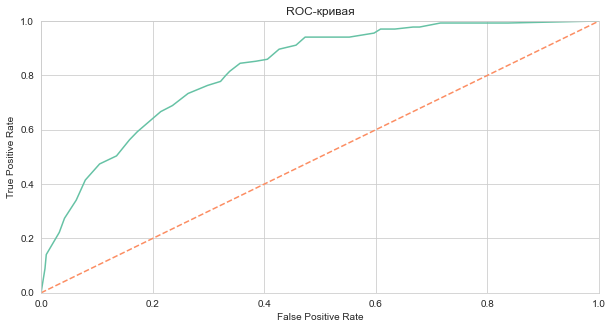

ROC-AUC:  0.8176206509539843


In [85]:
fpr, tpr, thresholds = roc_curve(y_test, DTC_pred_proba[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(y_test, DTC_pred_proba[:, 1])

print('ROC-AUC: ', auc_roc)

## Cat Boost

In [86]:
%%time
model = CatBoostClassifier(cat_features=cat_features)
model.fit(X_train, y_train, verbose=0)


CPU times: user 19.5 s, sys: 880 ms, total: 20.3 s
Wall time: 2.58 s


In [87]:
def validate(model, val_data):
    y = model.predict(val_data[0])
    y_proba = model.predict_proba(val_data[0])
    print('Accuracy =', accuracy_score(y, val_data[1]))
    print('ROC-AUC =', roc_auc_score(val_data[1], y_proba[:, 1]))
    print('F1 =', f1_score(y, val_data[1]))

    acc = accuracy_score(y, val_data[1])
    rocauc = roc_auc_score(val_data[1], y_proba[:, 1])

    return acc, rocauc, y_proba

In [88]:
validate(model, (X_valid, y_valid))

Accuracy = 0.7919254658385093
ROC-AUC = 0.8387308101036549
F1 = 0.5669436749769159


(0.7919254658385093,
 0.8387308101036549,
 array([[0.98424691, 0.01575309],
        [0.74753942, 0.25246058],
        [0.83074027, 0.16925973],
        ...,
        [0.10862912, 0.89137088],
        [0.35933058, 0.64066942],
        [0.64629829, 0.35370171]]))

In [89]:
def CB_search(trial, X_train=X_train, X_test=X_valid, y_train=y_train, y_test=y_valid):  
  
    params = { 
        'random_state': RANDOM,
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.01, step=0.1),
        'depth' : trial.suggest_int('depth', 9, 15),
        'l2_leaf_reg' : trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),
        'min_child_samples' : trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    }
    
    model_3 = CatBoostClassifier(**params, cat_features=cat_features) 
        
    model_3.fit(X_train, y_train, 
                eval_set=[(X_valid,y_valid)], 
                early_stopping_rounds=300, 
                #plot=True,
                verbose=500,
                use_best_model=True)

    preds = model_3.predict_proba(X_valid)
    
    roc_auc = roc_auc_score(y_valid, preds[:, 1])
    
    return roc_auc

In [90]:
CB_study = optuna.create_study(direction='maximize')
CB_study.optimize(CB_search, n_trials=30)

print('Лучший ROC-AUC:', CB_study.best_trial.value)

[I 2022-10-27 23:02:26,814] A new study created in memory with name: no-name-bf3580e7-598e-40e3-9e50-0d200812c745


0:	learn: 0.6930771	test: 0.6930792	best: 0.6930792 (0)	total: 7.17ms	remaining: 4.2s
500:	learn: 0.6611126	test: 0.6625806	best: 0.6625806 (500)	total: 5.12s	remaining: 869ms


[I 2022-10-27 23:02:33,365] Trial 0 finished with value: 0.8309186595926369 and parameters: {'n_estimators': 586, 'learning_rate': 0.0001, 'depth': 12, 'l2_leaf_reg': 4.5, 'min_child_samples': 16}. Best is trial 0 with value: 0.8309186595926369.


585:	learn: 0.6559716	test: 0.6577014	best: 0.6577014 (585)	total: 6.38s	remaining: 0us

bestTest = 0.6577014127
bestIteration = 585

0:	learn: 0.6930696	test: 0.6930764	best: 0.6930764 (0)	total: 19ms	remaining: 15.8s
500:	learn: 0.6604690	test: 0.6621111	best: 0.6621111 (500)	total: 3.92s	remaining: 2.58s


[I 2022-10-27 23:02:40,516] Trial 1 finished with value: 0.8318804532707446 and parameters: {'n_estimators': 831, 'learning_rate': 0.0001, 'depth': 11, 'l2_leaf_reg': 2.0, 'min_child_samples': 4}. Best is trial 1 with value: 0.8318804532707446.


830:	learn: 0.6410372	test: 0.6436976	best: 0.6436976 (830)	total: 6.88s	remaining: 0us

bestTest = 0.643697583
bestIteration = 830

0:	learn: 0.6930711	test: 0.6930815	best: 0.6930815 (0)	total: 96.4ms	remaining: 1m 8s
500:	learn: 0.6611411	test: 0.6626084	best: 0.6626084 (500)	total: 7.35s	remaining: 3.14s


[I 2022-10-27 23:02:51,574] Trial 2 finished with value: 0.8320807648223092 and parameters: {'n_estimators': 715, 'learning_rate': 0.0001, 'depth': 13, 'l2_leaf_reg': 3.0, 'min_child_samples': 4}. Best is trial 2 with value: 0.8320807648223092.


714:	learn: 0.6486593	test: 0.6506992	best: 0.6506992 (714)	total: 10.8s	remaining: 0us

bestTest = 0.6506992108
bestIteration = 714

0:	learn: 0.6930774	test: 0.6930794	best: 0.6930794 (0)	total: 8.04ms	remaining: 5.43s
500:	learn: 0.6613568	test: 0.6627246	best: 0.6627246 (500)	total: 3.77s	remaining: 1.32s


[I 2022-10-27 23:02:57,039] Trial 3 finished with value: 0.8311070419202868 and parameters: {'n_estimators': 677, 'learning_rate': 0.0001, 'depth': 11, 'l2_leaf_reg': 5.0, 'min_child_samples': 4}. Best is trial 2 with value: 0.8320807648223092.


676:	learn: 0.6510584	test: 0.6528785	best: 0.6528785 (676)	total: 5.03s	remaining: 0us

bestTest = 0.6528784934
bestIteration = 676

0:	learn: 0.6930736	test: 0.6930770	best: 0.6930770 (0)	total: 14.6ms	remaining: 8.71s
500:	learn: 0.6610011	test: 0.6624354	best: 0.6624354 (500)	total: 2.24s	remaining: 434ms


[I 2022-10-27 23:02:59,953] Trial 4 finished with value: 0.8309474885504302 and parameters: {'n_estimators': 598, 'learning_rate': 0.0001, 'depth': 9, 'l2_leaf_reg': 4.0, 'min_child_samples': 8}. Best is trial 2 with value: 0.8320807648223092.


597:	learn: 0.6552091	test: 0.6569203	best: 0.6569203 (597)	total: 2.76s	remaining: 0us

bestTest = 0.6569203054
bestIteration = 597

0:	learn: 0.6930771	test: 0.6930792	best: 0.6930792 (0)	total: 10.7ms	remaining: 7.47s
500:	learn: 0.6613076	test: 0.6626934	best: 0.6626934 (500)	total: 2.44s	remaining: 981ms


[I 2022-10-27 23:03:03,622] Trial 5 finished with value: 0.830705424715165 and parameters: {'n_estimators': 702, 'learning_rate': 0.0001, 'depth': 9, 'l2_leaf_reg': 4.5, 'min_child_samples': 1}. Best is trial 2 with value: 0.8320807648223092.


701:	learn: 0.6496365	test: 0.6515139	best: 0.6515139 (701)	total: 3.47s	remaining: 0us

bestTest = 0.6515139097
bestIteration = 701

0:	learn: 0.6930727	test: 0.6930761	best: 0.6930761 (0)	total: 17.8ms	remaining: 11.5s
500:	learn: 0.6613132	test: 0.6627057	best: 0.6627057 (500)	total: 2.38s	remaining: 688ms


[I 2022-10-27 23:03:06,899] Trial 6 finished with value: 0.8310076317209993 and parameters: {'n_estimators': 646, 'learning_rate': 0.0001, 'depth': 9, 'l2_leaf_reg': 3.5, 'min_child_samples': 16}. Best is trial 2 with value: 0.8320807648223092.


645:	learn: 0.6526549	test: 0.6544661	best: 0.6544661 (645)	total: 3.11s	remaining: 0us

bestTest = 0.6544660746
bestIteration = 645

0:	learn: 0.6930753	test: 0.6930780	best: 0.6930780 (0)	total: 6.19ms	remaining: 5.82s
500:	learn: 0.6603234	test: 0.6619683	best: 0.6619683 (500)	total: 2.91s	remaining: 2.56s


[I 2022-10-27 23:03:12,736] Trial 7 finished with value: 0.8314867888815656 and parameters: {'n_estimators': 941, 'learning_rate': 0.0001, 'depth': 10, 'l2_leaf_reg': 1.0, 'min_child_samples': 32}. Best is trial 2 with value: 0.8320807648223092.


940:	learn: 0.6347853	test: 0.6378140	best: 0.6378140 (940)	total: 5.57s	remaining: 0us

bestTest = 0.6378139969
bestIteration = 940

0:	learn: 0.6930767	test: 0.6930829	best: 0.6930829 (0)	total: 19.8ms	remaining: 15.6s
500:	learn: 0.6611128	test: 0.6625823	best: 0.6625823 (500)	total: 3.67s	remaining: 2.12s


[I 2022-10-27 23:03:18,915] Trial 8 finished with value: 0.8313774376623493 and parameters: {'n_estimators': 790, 'learning_rate': 0.0001, 'depth': 11, 'l2_leaf_reg': 4.0, 'min_child_samples': 1}. Best is trial 2 with value: 0.8320807648223092.


789:	learn: 0.6443390	test: 0.6465824	best: 0.6465824 (789)	total: 5.91s	remaining: 0us

bestTest = 0.64658238
bestIteration = 789

0:	learn: 0.6930732	test: 0.6930832	best: 0.6930832 (0)	total: 101ms	remaining: 1m 4s
500:	learn: 0.6611233	test: 0.6626457	best: 0.6626457 (500)	total: 9.17s	remaining: 2.53s


[I 2022-10-27 23:03:30,617] Trial 9 finished with value: 0.8313406558886128 and parameters: {'n_estimators': 639, 'learning_rate': 0.0001, 'depth': 13, 'l2_leaf_reg': 3.5, 'min_child_samples': 16}. Best is trial 2 with value: 0.8320807648223092.


638:	learn: 0.6529946	test: 0.6548977	best: 0.6548977 (638)	total: 11.5s	remaining: 0us

bestTest = 0.6548977048
bestIteration = 638

0:	learn: 0.6930697	test: 0.6930849	best: 0.6930849 (0)	total: 373ms	remaining: 5m 32s
500:	learn: 0.6612450	test: 0.6627122	best: 0.6627122 (500)	total: 18.3s	remaining: 14.3s


[I 2022-10-27 23:04:06,975] Trial 10 finished with value: 0.8319147497894989 and parameters: {'n_estimators': 891, 'learning_rate': 0.0001, 'depth': 15, 'l2_leaf_reg': 2.5, 'min_child_samples': 4}. Best is trial 2 with value: 0.8320807648223092.


890:	learn: 0.6389948	test: 0.6416271	best: 0.6416271 (890)	total: 36s	remaining: 0us

bestTest = 0.6416271403
bestIteration = 890

0:	learn: 0.6930697	test: 0.6930849	best: 0.6930849 (0)	total: 398ms	remaining: 6m 3s
500:	learn: 0.6612450	test: 0.6627122	best: 0.6627122 (500)	total: 18.9s	remaining: 15.6s


[I 2022-10-27 23:04:45,484] Trial 11 finished with value: 0.8319515315632354 and parameters: {'n_estimators': 916, 'learning_rate': 0.0001, 'depth': 15, 'l2_leaf_reg': 2.5, 'min_child_samples': 4}. Best is trial 2 with value: 0.8320807648223092.


915:	learn: 0.6375998	test: 0.6403145	best: 0.6403145 (915)	total: 38.1s	remaining: 0us

bestTest = 0.6403145096
bestIteration = 915

0:	learn: 0.6930697	test: 0.6930849	best: 0.6930849 (0)	total: 383ms	remaining: 3m 12s


[I 2022-10-27 23:05:05,021] Trial 12 finished with value: 0.8317149352889308 and parameters: {'n_estimators': 504, 'learning_rate': 0.0001, 'depth': 15, 'l2_leaf_reg': 2.5, 'min_child_samples': 4}. Best is trial 2 with value: 0.8320807648223092.


500:	learn: 0.6612450	test: 0.6627122	best: 0.6627122 (500)	total: 19.3s	remaining: 116ms
503:	learn: 0.6610603	test: 0.6625366	best: 0.6625366 (503)	total: 19.4s	remaining: 0us

bestTest = 0.6625365905
bestIteration = 503

0:	learn: 0.6930756	test: 0.6930781	best: 0.6930781 (0)	total: 6.29ms	remaining: 6.05s
500:	learn: 0.6601727	test: 0.6622669	best: 0.6622669 (500)	total: 16.4s	remaining: 15.1s


[I 2022-10-27 23:05:36,865] Trial 13 finished with value: 0.8313381706336308 and parameters: {'n_estimators': 964, 'learning_rate': 0.0001, 'depth': 14, 'l2_leaf_reg': 1.5, 'min_child_samples': 4}. Best is trial 2 with value: 0.8320807648223092.


963:	learn: 0.6332829	test: 0.6371161	best: 0.6371161 (963)	total: 31.6s	remaining: 0us

bestTest = 0.637116053
bestIteration = 963

0:	learn: 0.6930686	test: 0.6930795	best: 0.6930795 (0)	total: 88.7ms	remaining: 1m 6s
500:	learn: 0.6608184	test: 0.6624183	best: 0.6624183 (500)	total: 8.74s	remaining: 4.36s


[I 2022-10-27 23:05:49,541] Trial 14 finished with value: 0.8322800822718809 and parameters: {'n_estimators': 751, 'learning_rate': 0.0001, 'depth': 13, 'l2_leaf_reg': 2.5, 'min_child_samples': 32}. Best is trial 14 with value: 0.8322800822718809.


750:	learn: 0.6463743	test: 0.6486363	best: 0.6486363 (750)	total: 12.5s	remaining: 0us

bestTest = 0.6486363361
bestIteration = 750

0:	learn: 0.6930711	test: 0.6930815	best: 0.6930815 (0)	total: 81.9ms	remaining: 1m 1s
500:	learn: 0.6611411	test: 0.6626084	best: 0.6626084 (500)	total: 7.34s	remaining: 3.72s


[I 2022-10-27 23:06:00,713] Trial 15 finished with value: 0.8320549181704946 and parameters: {'n_estimators': 755, 'learning_rate': 0.0001, 'depth': 13, 'l2_leaf_reg': 3.0, 'min_child_samples': 32}. Best is trial 14 with value: 0.8322800822718809.


754:	learn: 0.6464342	test: 0.6485774	best: 0.6485774 (754)	total: 10.9s	remaining: 0us

bestTest = 0.6485774424
bestIteration = 754

0:	learn: 0.6930756	test: 0.6930781	best: 0.6930781 (0)	total: 6.48ms	remaining: 5.41s
500:	learn: 0.6600804	test: 0.6620366	best: 0.6620366 (500)	total: 8.85s	remaining: 5.92s


[I 2022-10-27 23:06:16,059] Trial 16 finished with value: 0.8312024757116032 and parameters: {'n_estimators': 836, 'learning_rate': 0.0001, 'depth': 13, 'l2_leaf_reg': 1.5, 'min_child_samples': 32}. Best is trial 14 with value: 0.8322800822718809.


835:	learn: 0.6403200	test: 0.6434746	best: 0.6434746 (835)	total: 15.1s	remaining: 0us

bestTest = 0.6434745585
bestIteration = 835

0:	learn: 0.6930776	test: 0.6930796	best: 0.6930796 (0)	total: 6.75ms	remaining: 4.91s
500:	learn: 0.6614400	test: 0.6628423	best: 0.6628423 (500)	total: 13.9s	remaining: 6.34s


[I 2022-10-27 23:06:36,574] Trial 17 finished with value: 0.8312377663323502 and parameters: {'n_estimators': 729, 'learning_rate': 0.0001, 'depth': 14, 'l2_leaf_reg': 5.5, 'min_child_samples': 8}. Best is trial 14 with value: 0.8322800822718809.


728:	learn: 0.6482225	test: 0.6502254	best: 0.6502254 (728)	total: 20.3s	remaining: 0us

bestTest = 0.6502254217
bestIteration = 728

0:	learn: 0.6930727	test: 0.6930829	best: 0.6930829 (0)	total: 37.8ms	remaining: 29.4s
500:	learn: 0.6610863	test: 0.6626242	best: 0.6626242 (500)	total: 5.39s	remaining: 2.98s


[I 2022-10-27 23:06:45,418] Trial 18 finished with value: 0.8314728714536654 and parameters: {'n_estimators': 778, 'learning_rate': 0.0001, 'depth': 12, 'l2_leaf_reg': 3.0, 'min_child_samples': 32}. Best is trial 14 with value: 0.8322800822718809.


777:	learn: 0.6449611	test: 0.6472898	best: 0.6472898 (777)	total: 8.58s	remaining: 0us

bestTest = 0.6472898387
bestIteration = 777

0:	learn: 0.6930656	test: 0.6930805	best: 0.6930805 (0)	total: 184ms	remaining: 2m 35s
500:	learn: 0.6608276	test: 0.6625546	best: 0.6625546 (500)	total: 13.5s	remaining: 9.33s


[I 2022-10-27 23:07:09,025] Trial 19 finished with value: 0.8311801084167633 and parameters: {'n_estimators': 848, 'learning_rate': 0.0001, 'depth': 14, 'l2_leaf_reg': 2.0, 'min_child_samples': 32}. Best is trial 14 with value: 0.8322800822718809.


847:	learn: 0.6406849	test: 0.6435163	best: 0.6435163 (847)	total: 23.4s	remaining: 0us

bestTest = 0.6435163252
bestIteration = 847

0:	learn: 0.6930656	test: 0.6930771	best: 0.6930771 (0)	total: 83.6ms	remaining: 42.4s


[I 2022-10-27 23:07:16,874] Trial 20 finished with value: 0.8316880945351233 and parameters: {'n_estimators': 508, 'learning_rate': 0.0001, 'depth': 13, 'l2_leaf_reg': 2.0, 'min_child_samples': 8}. Best is trial 14 with value: 0.8322800822718809.


500:	learn: 0.6609053	test: 0.6625944	best: 0.6625944 (500)	total: 7.65s	remaining: 107ms
507:	learn: 0.6604897	test: 0.6621972	best: 0.6621972 (507)	total: 7.71s	remaining: 0us

bestTest = 0.6621971607
bestIteration = 507

0:	learn: 0.6930711	test: 0.6930815	best: 0.6930815 (0)	total: 81.9ms	remaining: 1m 1s
500:	learn: 0.6611411	test: 0.6626084	best: 0.6626084 (500)	total: 7.28s	remaining: 3.62s


[I 2022-10-27 23:07:27,796] Trial 21 finished with value: 0.8320410007425943 and parameters: {'n_estimators': 750, 'learning_rate': 0.0001, 'depth': 13, 'l2_leaf_reg': 3.0, 'min_child_samples': 32}. Best is trial 14 with value: 0.8322800822718809.


749:	learn: 0.6467087	test: 0.6488394	best: 0.6488394 (749)	total: 10.8s	remaining: 0us

bestTest = 0.6488394345
bestIteration = 749

0:	learn: 0.6930727	test: 0.6930829	best: 0.6930829 (0)	total: 39.2ms	remaining: 30.3s
500:	learn: 0.6610863	test: 0.6626242	best: 0.6626242 (500)	total: 5.39s	remaining: 2.94s


[I 2022-10-27 23:07:36,450] Trial 22 finished with value: 0.8315026945134515 and parameters: {'n_estimators': 774, 'learning_rate': 0.0001, 'depth': 12, 'l2_leaf_reg': 3.0, 'min_child_samples': 32}. Best is trial 14 with value: 0.8322800822718809.


773:	learn: 0.6451981	test: 0.6475119	best: 0.6475119 (773)	total: 8.45s	remaining: 0us

bestTest = 0.6475119411
bestIteration = 773

0:	learn: 0.6930733	test: 0.6930845	best: 0.6930845 (0)	total: 184ms	remaining: 2m 10s
500:	learn: 0.6612921	test: 0.6627394	best: 0.6627394 (500)	total: 13s	remaining: 5.37s


[I 2022-10-27 23:07:54,985] Trial 23 finished with value: 0.8316433599454436 and parameters: {'n_estimators': 708, 'learning_rate': 0.0001, 'depth': 14, 'l2_leaf_reg': 3.5, 'min_child_samples': 32}. Best is trial 14 with value: 0.8322800822718809.


707:	learn: 0.6492841	test: 0.6512990	best: 0.6512990 (707)	total: 18.3s	remaining: 0us

bestTest = 0.6512990391
bestIteration = 707

0:	learn: 0.6930686	test: 0.6930795	best: 0.6930795 (0)	total: 80.9ms	remaining: 53.7s
500:	learn: 0.6608184	test: 0.6624183	best: 0.6624183 (500)	total: 8.59s	remaining: 2.81s


[I 2022-10-27 23:08:06,247] Trial 24 finished with value: 0.8323143787906353 and parameters: {'n_estimators': 665, 'learning_rate': 0.0001, 'depth': 13, 'l2_leaf_reg': 2.5, 'min_child_samples': 32}. Best is trial 24 with value: 0.8323143787906353.


664:	learn: 0.6512420	test: 0.6532696	best: 0.6532696 (664)	total: 11.1s	remaining: 0us

bestTest = 0.6532695618
bestIteration = 664

0:	learn: 0.6930703	test: 0.6930810	best: 0.6930810 (0)	total: 39.2ms	remaining: 25.9s
500:	learn: 0.6605210	test: 0.6622583	best: 0.6622583 (500)	total: 5.8s	remaining: 1.85s


[I 2022-10-27 23:08:13,876] Trial 25 finished with value: 0.830938044581498 and parameters: {'n_estimators': 661, 'learning_rate': 0.0001, 'depth': 12, 'l2_leaf_reg': 2.5, 'min_child_samples': 1}. Best is trial 24 with value: 0.8323143787906353.


660:	learn: 0.6510510	test: 0.6532801	best: 0.6532801 (660)	total: 7.41s	remaining: 0us

bestTest = 0.6532800868
bestIteration = 660

0:	learn: 0.6930756	test: 0.6930781	best: 0.6930781 (0)	total: 6.79ms	remaining: 3.94s
500:	learn: 0.6601727	test: 0.6622669	best: 0.6622669 (500)	total: 16.7s	remaining: 2.69s


[I 2022-10-27 23:08:33,121] Trial 26 finished with value: 0.8310309931178319 and parameters: {'n_estimators': 582, 'learning_rate': 0.0001, 'depth': 14, 'l2_leaf_reg': 1.5, 'min_child_samples': 32}. Best is trial 24 with value: 0.8323143787906353.


581:	learn: 0.6552625	test: 0.6576841	best: 0.6576841 (581)	total: 19.1s	remaining: 0us

bestTest = 0.6576840702
bestIteration = 581

0:	learn: 0.6930656	test: 0.6930771	best: 0.6930771 (0)	total: 83.2ms	remaining: 51s
500:	learn: 0.6609053	test: 0.6625944	best: 0.6625944 (500)	total: 7.65s	remaining: 1.73s


[I 2022-10-27 23:08:43,030] Trial 27 finished with value: 0.8317894929383965 and parameters: {'n_estimators': 614, 'learning_rate': 0.0001, 'depth': 13, 'l2_leaf_reg': 2.0, 'min_child_samples': 32}. Best is trial 24 with value: 0.8323143787906353.


613:	learn: 0.6540764	test: 0.6561448	best: 0.6561448 (613)	total: 9.68s	remaining: 0us

bestTest = 0.6561448298
bestIteration = 613

0:	learn: 0.6930753	test: 0.6930780	best: 0.6930780 (0)	total: 6.76ms	remaining: 3.7s
500:	learn: 0.6599475	test: 0.6618477	best: 0.6618477 (500)	total: 3.68s	remaining: 352ms


[I 2022-10-27 23:08:47,153] Trial 28 finished with value: 0.831271565800108 and parameters: {'n_estimators': 549, 'learning_rate': 0.0001, 'depth': 11, 'l2_leaf_reg': 1.0, 'min_child_samples': 4}. Best is trial 24 with value: 0.8323143787906353.


548:	learn: 0.6569726	test: 0.6590457	best: 0.6590457 (548)	total: 3.99s	remaining: 0us

bestTest = 0.6590456911
bestIteration = 548

0:	learn: 0.6930767	test: 0.6930829	best: 0.6930829 (0)	total: 38.7ms	remaining: 26.7s
500:	learn: 0.6609174	test: 0.6624536	best: 0.6624536 (500)	total: 5.09s	remaining: 1.94s


[I 2022-10-27 23:08:54,284] Trial 29 finished with value: 0.8309912290381167 and parameters: {'n_estimators': 692, 'learning_rate': 0.0001, 'depth': 12, 'l2_leaf_reg': 4.0, 'min_child_samples': 16}. Best is trial 24 with value: 0.8323143787906353.


691:	learn: 0.6497852	test: 0.6518433	best: 0.6518433 (691)	total: 6.95s	remaining: 0us

bestTest = 0.6518432517
bestIteration = 691

Лучший ROC-AUC: 0.8323143787906353


In [91]:
CB_model = CatBoostClassifier(**CB_study.best_params, cat_features=cat_features)
CB_model.fit(X_train, y_train, verbose=500)
CB_pred_proba = CB_model.predict_proba(X_test)
CB_pred = CB_model.predict(X_test)
CB_rocauc = roc_auc_score(y_test, CB_pred_proba[:, 1])
print(f'ROC-AUC  на тестовой выборке: {CB_rocauc}')
print(f'Accuracy на тестовой выборке: {roc_auc_score(CB_pred, y_test)}')

0:	learn: 0.6931021	total: 2.52ms	remaining: 1.67s
500:	learn: 0.6606709	total: 8.42s	remaining: 2.75s
664:	learn: 0.6507115	total: 11.6s	remaining: 0us
ROC-AUC  на тестовой выборке: 0.8325304325304325
Accuracy на тестовой выборке: 0.7040078201368525


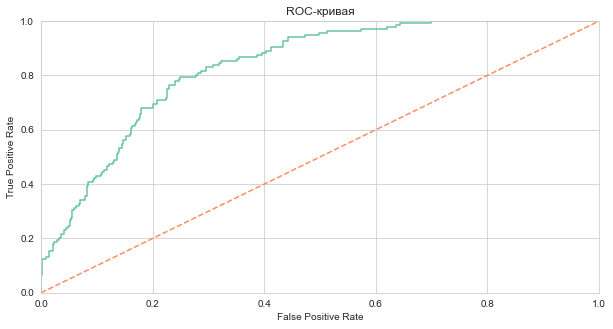

ROC-AUC:  0.8325304325304325


In [92]:
fpr, tpr, thresholds = roc_curve(y_test, CB_pred_proba[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(y_test, CB_pred_proba[:, 1])

print('ROC-AUC: ', auc_roc)

## Нейронная сеть

In [93]:
def create_model():
    NET_model = Sequential()
    NET_model.add(Dense(units=15, input_dim=X_train_conv.shape[1], activation='relu'))
    NET_model.add(Dense(units=40, activation='relu'))
    NET_model.add(Dense(1, activation='sigmoid'))
    NET_model.compile(loss='binary_crossentropy', metrics=['AUC'])

    return NET_model


In [94]:
NET_model = create_model()
NET_model.fit(X_train_conv, y_train, batch_size=32, epochs=5)
NET_model_pred_proba = NET_model.predict(X_valid_conv)
NET_rocauc = roc_auc_score(y_valid, NET_model_pred_proba)

print(f'ROC-AUC нейронки: {NET_rocauc}')

2022-10-27 23:09:06.430910: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
133/133 [==============================] - 1s 950us/step - loss: 0.5411 - auc: 0.6786
Epoch 2/5
133/133 [==============================] - 0s 752us/step - loss: 0.4486 - auc: 0.8149
Epoch 3/5
133/133 [==============================] - 0s 852us/step - loss: 0.4353 - auc: 0.8276
Epoch 4/5
133/133 [==============================] - 0s 816us/step - loss: 0.4306 - auc: 0.8325
Epoch 5/5
133/133 [==============================] - 0s 720us/step - loss: 0.4282 - auc: 0.8343
ROC-AUC нейронки: 0.8310573368206431


In [95]:
NET_model_pred_proba = NET_model.predict(X_test_conv)
NET_rocauc = roc_auc_score(y_test, NET_model_pred_proba)

print(f'ROC-AUC нейронки: {NET_rocauc}')

ROC-AUC нейронки: 0.8309591642924976


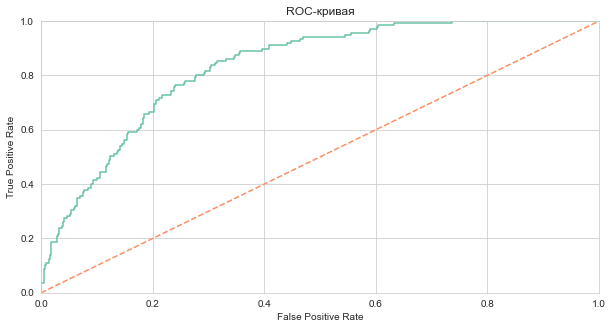

ROC-AUC:  0.8309591642924976


In [96]:
fpr, tpr, thresholds = roc_curve(y_test, NET_model_pred_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print('ROC-AUC: ', NET_rocauc)

## Общая таблица моделей

In [97]:
models = {'score' : [round(num, 3) for num in [DTC_rocauc, CB_rocauc, NET_rocauc]], 
        'model' : [DTC, CB_model, NET_model], 
        'preds' : [DTC_pred, CB_pred, NET_model_pred_proba]}

mod_rates = pd.DataFrame(models, index=['Decision Tree', 'CatBoost', 'NET model']).sort_values('score', ascending=False)

mod_rates[mod_rates.columns[:1]]

score
CatBoost       0.833
NET model      0.831
Decision Tree  0.818

### Лучшая модель и ее анализ

**Лучшая модель**

Проверив и сравнив 3 модели видим:

CatBoot показала лучший результат среди выбранных моделей

Посмотрим на параметры получше

#### **Confusion matrix**

In [98]:
def cf_print(y_test, preds):
    matrix_confusion = confusion_matrix(y_test, preds)
    sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [99]:
def best_cf(y_test, best_model):
    if type(best_model['model']) == type(NET_model):
        NET_cf = np.round(best_model['preds']).tolist()
        cf_print(y_test, NET_cf)
    else:
        cf_print(y_test, best_model['preds'])


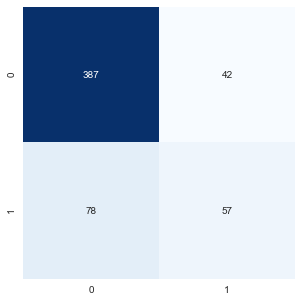

In [100]:
best_cf(y_test, mod_rates.iloc[0])

**Вывод**

Чаще модель ошибается в определении, что клиент уйдет.

С точки зрения бизнеса это может означать ненужные затраты на удержание клиентов, которые и так НЕ планировали уходить. 

С точки зрения клиента - повышенное внимание с предложениями ненужных доп функций может наоборот вызвать раздражение) Но при этом вряд ли отпугнет клиента от дальнейшего использования сервиса.

In [101]:
CB_study.best_params

{'n_estimators': 665,
 'learning_rate': 0.0001,
 'depth': 13,
 'l2_leaf_reg': 2.5,
 'min_child_samples': 32}

In [105]:
best_features = pd.DataFrame(CB_model.feature_importances_, 
                            index=[cat_features + num_features], 
                            columns=['score']).sort_values('score', 
                            ascending=False)

best_features = best_features.reset_index()

best_features.columns = ['feature', 'score']

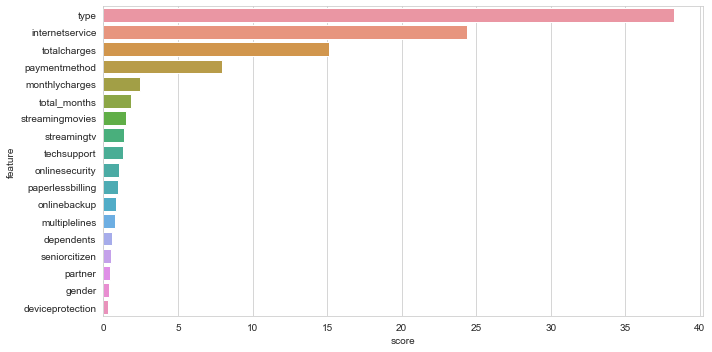

In [106]:
sns.barplot(data=best_features, x='score', y='feature')
# plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

1. Провел эксперименты на 3х различных моделях.
2. В двух моделях использовал подбор гиперпараметров.
3. На тесте получил необходимый уровень метрики.
4. Сделал вывод важности признаков.

## Вывод

Мы достигли поставленной цели точности модели в 0.78

Лучшая модель показывает результат 0.83, что довольно точно позволяет предсказать вероятность ухода клиента.

Самые важные признаки/показатели, которые указывают на вероятность ухода клиента:
- Тип оплаты контракта.
- Тип интернета
- Общие траты клиента
- Способ оплаты за услуги

Очевидно, что клиенты, которые берут оплату Раз в год или Раз в два года - намерены пользоваться сервисом дольше, чем клиенты, которые берут помесячную оплату.

Одинокий человек или с семьей - не имеет никакого влияния на результат.


## **Финальный отчет о проделанной работе**



<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-библиотек" data-toc-modified-id="Загрузка-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка библиотек</a></span></li><li><span><a href="#Подключение-к-базе-и-первичный-осмотр" data-toc-modified-id="Подключение-к-базе-и-первичный-осмотр-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подключение к базе и первичный осмотр</a></span><ul class="toc-item"><li><span><a href="#Personal" data-toc-modified-id="Personal-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Personal</a></span></li><li><span><a href="#Phone" data-toc-modified-id="Phone-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Phone</a></span></li><li><span><a href="#Contract" data-toc-modified-id="Contract-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Contract</a></span></li><li><span><a href="#Internet" data-toc-modified-id="Internet-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Internet</a></span></li></ul></li><li><span><a href="#Сравнение-групп" data-toc-modified-id="Сравнение-групп-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Сравнение групп</a></span><ul class="toc-item"><li><span><a href="#Target" data-toc-modified-id="Target-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Target</a></span></li><li><span><a href="#Визуализация-групп" data-toc-modified-id="Визуализация-групп-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Визуализация групп</a></span></li><li><span><a href="#Портрет-уходящего-клиента" data-toc-modified-id="Портрет-уходящего-клиента-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Портрет уходящего клиента</a></span></li></ul></li><li><span><a href="#Объединение-датасета" data-toc-modified-id="Объединение-датасета-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Объединение датасета</a></span><ul class="toc-item"><li><span><a href="#Обработка-пропусков" data-toc-modified-id="Обработка-пропусков-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Обработка пропусков</a></span></li></ul></li><li><span><a href="#Оценка-корреляции-с-таргетом" data-toc-modified-id="Оценка-корреляции-с-таргетом-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Оценка корреляции с таргетом</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Подготовка-к-модели" data-toc-modified-id="Подготовка-к-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Подготовка к модели</a></span><ul class="toc-item"><li><span><a href="#Определение-категориальных-и-числовых-признаков" data-toc-modified-id="Определение-категориальных-и-числовых-признаков-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Определение категориальных и числовых признаков</a></span></li><li><span><a href="#Разбиение-на-трейн-и-тест" data-toc-modified-id="Разбиение-на-трейн-и-тест-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Разбиение на трейн и тест</a></span></li><li><span><a href="#OrdinalEncoder" data-toc-modified-id="OrdinalEncoder-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>OrdinalEncoder</a></span></li><li><span><a href="#Scaler" data-toc-modified-id="Scaler-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Scaler</a></span></li><li><span><a href="#Объединение-закодированного-датасета" data-toc-modified-id="Объединение-закодированного-датасета-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Объединение закодированного датасета</a></span></li></ul></li><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Decision Tree</a></span></li><li><span><a href="#Cat-Boost" data-toc-modified-id="Cat-Boost-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Cat Boost</a></span></li><li><span><a href="#Нейронная-сеть" data-toc-modified-id="Нейронная-сеть-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Нейронная сеть</a></span></li><li><span><a href="#Общая-таблица-моделей" data-toc-modified-id="Общая-таблица-моделей-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Общая таблица моделей</a></span><ul class="toc-item"><li><span><a href="#Лучшая-модель-и-ее-анализ" data-toc-modified-id="Лучшая-модель-и-ее-анализ-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Лучшая модель и ее анализ</a></span><ul class="toc-item"><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-10.1.1"><span class="toc-item-num">10.1.1&nbsp;&nbsp;</span><strong>Confusion matrix</strong></a></span></li></ul></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Финальный-отчет-о-проделанной-работе" data-toc-modified-id="Финальный-отчет-о-проделанной-работе-12"><span class="toc-item-num">12&nbsp;&nbsp;</span><strong>Финальный отчет о проделанной работе</strong></a></span></li></ul></div>

**Цели задачи:**
- Создать модель предсказания оттока клиентов телеком компании
- Точность модели оценивается метрикой ROC AUC
- Достичь метрики предсказания не ниже 0.78

**План работы**
- Первичный анализ:
    - Произвести загрузку датасетов с сервера
    - Провести первичный осмотр, сделать анализ, исправить неправильные типы данныъ
    - Сравнить поведение двух групп клиентов - текущих и ушедших 
    - Сформировать портрет уходящего клиента
- Создание единого датасета:
    - Обработать пропуски/выбросы
    - Очистка, если необходима
    - Оценка влияния фичей на таргет
- Подготовка датасета для обучения и тестирования:
    - Определить кат.признаки и числовые
    - Произвести скалирование и кодирование признаков
- Поиск лучшей модели:
    - Решающее дерево
    - Бустинг
    - Нейронка
- Тестирование лучшей модели, визуализация
- Вывод
